# Imports

In [27]:
import os
import sys
from typing import Dict, List, Optional, Sequence, TextIO
import numpy as np
import pandas as pd
import urllib.request
import pickle
import matplotlib.pyplot as plt


import tensorflow as tf
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

from DS_2_2024_HW2_efficient_net import EfficientNet

In [28]:
tf.keras.utils.set_random_seed(16)

# Data

In [29]:
# Height, width and number of channels
H: int = 224
W: int = 224
C: int = 3
LABELS: int = 34
    
# Declare functions
def parse(example) -> Dict[str, tf.Tensor]:
    example = tf.io.parse_single_example(example, {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)})
    example["image"] = tf.image.convert_image_dtype(tf.image.decode_jpeg(example["image"], channels=3), tf.float32)
    example["mask"] = tf.image.convert_image_dtype(tf.image.decode_png(example["mask"], channels=1), tf.float32)
    return example


In [56]:
# Load data. Train & Dev datasets are stored as tfrecord objects (see https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)-
train = tf.data.TFRecordDataset("hw2_trainsample.tfrecord")
dev = tf.data.TFRecordDataset("hw2_devsample.tfrecord")

# Process data. Train & Dev are decoded from jpeg; Test data are constructed from list.
train = train.map(parse)
dev = dev.map(parse)

In [31]:
# test = tf.data.Dataset.from_tensor_slices(test) # see https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# To nejde načíst teď... načte se to až na konci

## Data exploration

In [32]:
# Zobrazení informací o první hodnotě datasetu
for example in train.take(1):
    print("Data types and shapes:")
    for key, value in example.items():
        print(f"{key}: dtype={value.dtype}, shape={value.shape}")

Data types and shapes:
image: dtype=<dtype: 'float32'>, shape=(224, 224, 3)
label: dtype=<dtype: 'int64'>, shape=()
mask: dtype=<dtype: 'float32'>, shape=(224, 224, 1)


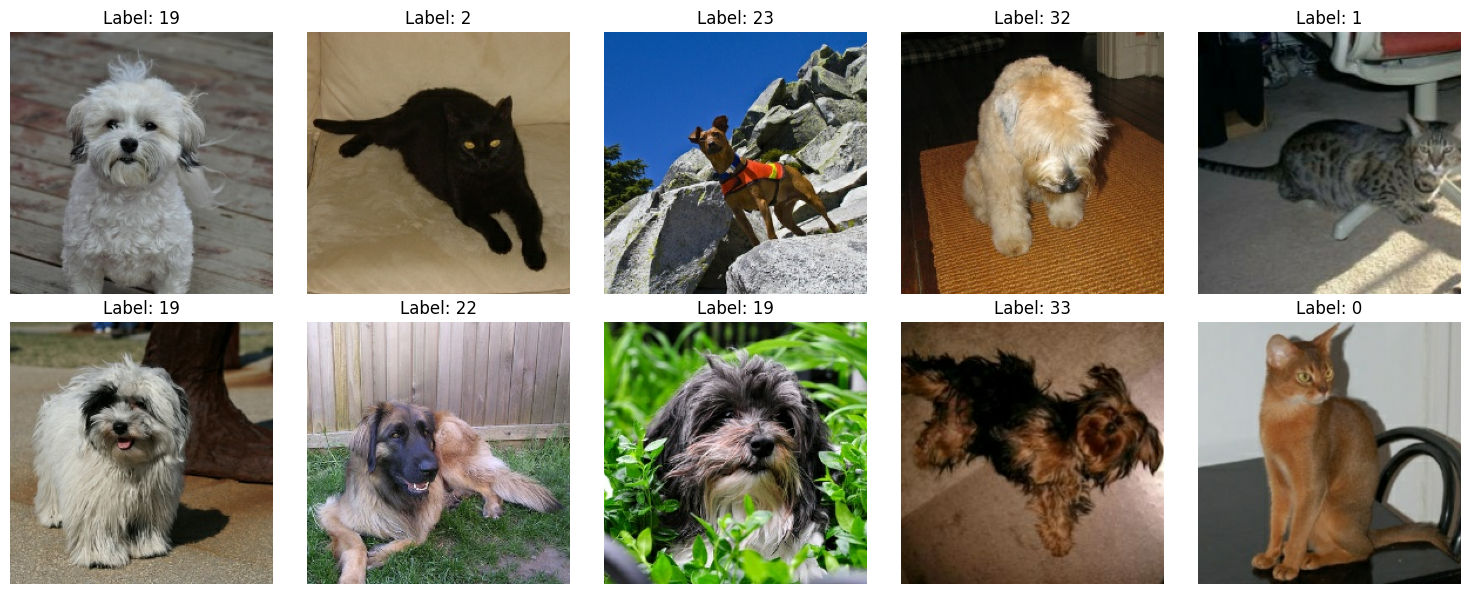

In [33]:
# Zobrazení prvních 10 obrázků

def show_images(dataset, num_images):
    num_cols = 5  # Počet obrázků na řádek
    num_rows = (num_images + num_cols - 1) // num_cols  # Počet řádků potřebný pro zobrazení num_images obrázků
    plt.figure(figsize=(num_cols * 3, num_rows * 3))
    
    # Použití enumerate pro získání indexu a obrázků
    for i, images in enumerate(dataset.take(num_images)):
        image = images['image']
        label = images['label']
        plt.subplot(num_rows, num_cols, i + 1)  # Řádky, sloupce a index obrázku
        plt.imshow(image.numpy())  # Zobrazení obrázku
        plt.title(f"Label: {label.numpy()}")  # Titulek s štítkem
        plt.axis("off")  # Skrytí os pro čistší zobrazení
        
    plt.tight_layout()  # Přizpůsobení layoutu pro zamezení překryvu
    plt.show()


show_images(train, 10)  # Změna num_images na počet obrázků, které chceme zobrazit


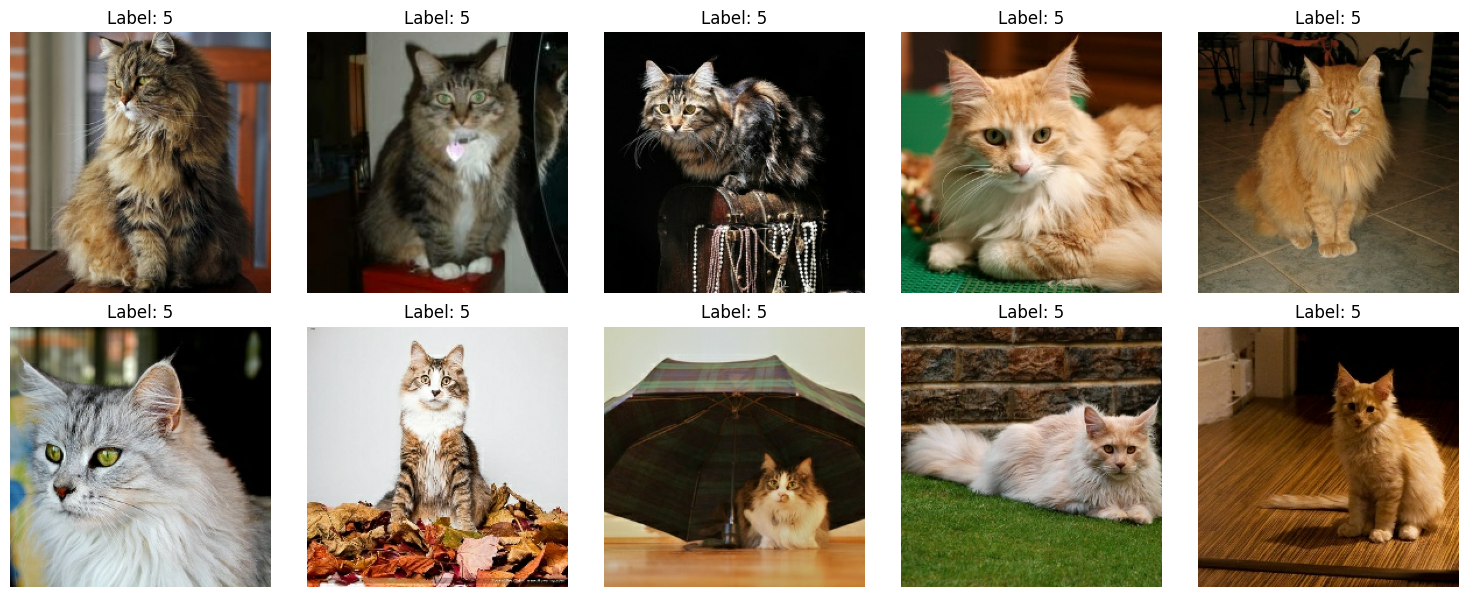

In [89]:
# Zobrazení konrétního plemene (např. 13)

def show_images_by_label(dataset, specific_label, num_images):
    num_cols = 5  # Počet obrázků na řádek
    filtered_data = dataset.filter(lambda x: x['label'] == specific_label)  # Filtrace datasetu podle štítku
    
    # Vytvoření figure s dostatečným počtem subplotů
    plt.figure(figsize=(num_cols * 3, ((num_images // num_cols) + 1) * 3))
    
    # Iterace přes filtrovaný dataset a zobrazení prvních `num_images` obrázků
    for i, images in enumerate(filtered_data.take(num_images)):
        image = images['image']
        label = images['label']
        plt.subplot((num_images // num_cols) + 1, num_cols, i + 1)  # Přidání obrázku do mřížky
        plt.imshow(image.numpy())  # Zobrazení obrázku
        plt.title(f"Label: {label.numpy()}")  # Titulek s štítkem
        plt.axis("off")  # Skrytí os pro čistší zobrazení

    plt.tight_layout()  # Přizpůsobení layoutu pro zamezení překryvu
    plt.show()

# Předpokládá se, že 'train' je již připravený tf.data.Dataset, který byl přemapován funkcí `parse`
specific_label = 5 # Příklad štítku, který chceme zobrazit
show_images_by_label(train, specific_label, 10)  # Změna na počet obrázků, které chceme zobrazit


In [35]:
# Počet obrázků pro každý label v train datasetu

def count_labels(dataset):
    # Vytvoříme proměnnou pro ukládání počtu štítků
    label_counts = tf.zeros([LABELS], dtype=tf.int32)
    
    # Projdeme dataset a pro každý štítek inkrementujeme jeho počet
    for features in dataset:
        # Přetypujeme label na tf.int32 pro indexaci
        label = tf.cast(features['label'], tf.int32)
        indices = tf.reshape(label, [-1])  # Zajistíme správný tvar pro tf.one_hot
        one_hot_labels = tf.one_hot(indices, depth=LABELS, dtype=tf.int32)
        label_counts += tf.reduce_sum(one_hot_labels, axis=0)
    
    # Vrátíme label_counts jako numpy array pro snadnější manipulaci a výpis
    return label_counts.numpy()

# Zavoláme funkci a vypíšeme výsledky
label_counts = count_labels(train)
print("Label counts:")
for label in range(LABELS):
    print(f"Label {label}: {label_counts[label]}")


Label counts:
Label 0: 63
Label 1: 63
Label 2: 63
Label 3: 63
Label 4: 63
Label 5: 63
Label 6: 63
Label 7: 63
Label 8: 63
Label 9: 63
Label 10: 63
Label 11: 63
Label 12: 63
Label 13: 63
Label 14: 63
Label 15: 63
Label 16: 63
Label 17: 63
Label 18: 63
Label 19: 63
Label 20: 63
Label 21: 63
Label 22: 63
Label 23: 63
Label 24: 63
Label 25: 63
Label 26: 63
Label 27: 63
Label 28: 63
Label 29: 63
Label 30: 63
Label 31: 63
Label 32: 63
Label 33: 63


In [36]:
# Počet obrázků pro každý label v dev datasetu

def count_labels(dataset):
    # Vytvoříme proměnnou pro ukládání počtu štítků
    # Ujistěte se, že LABELS je správný počet štítků
    label_counts = tf.zeros([LABELS], dtype=tf.int32)
    
    # Projdeme dataset a pro každý štítek inkrementujeme jeho počet
    for features in dataset:
        # Přetypujeme label na tf.int32 pro indexaci
        label = tf.cast(features['label'], tf.int32)
        indices = tf.reshape(label, [-1])  # Zajistíme správný tvar pro tf.one_hot
        one_hot_labels = tf.one_hot(indices, depth=LABELS, dtype=tf.int32)
        label_counts += tf.reduce_sum(one_hot_labels, axis=0)
    
    # Vrátíme label_counts jako numpy array pro snadnější manipulaci a výpis
    return label_counts.numpy()

# Zavoláme funkci a vypíšeme výsledky
label_counts = count_labels(dev)
print("Label counts:")
for label in range(LABELS):
    print(f"Label {label}: {label_counts[label]}")

Label counts:
Label 0: 9
Label 1: 9
Label 2: 9
Label 3: 9
Label 4: 9
Label 5: 9
Label 6: 9
Label 7: 9
Label 8: 9
Label 9: 9
Label 10: 9
Label 11: 9
Label 12: 9
Label 13: 9
Label 14: 9
Label 15: 9
Label 16: 9
Label 17: 9
Label 18: 9
Label 19: 9
Label 20: 9
Label 21: 9
Label 22: 9
Label 23: 9
Label 24: 9
Label 25: 9
Label 26: 9
Label 27: 9
Label 28: 9
Label 29: 9
Label 30: 9
Label 31: 9
Label 32: 9
Label 33: 9


In [37]:
# Počet obrázků pro v train a dev

dataset_size = train.reduce(0, lambda x, _: x + 1)
print(f"Total number of train samples in the dataset: {dataset_size.numpy()}")
dataset_size = dev.reduce(0, lambda x, _: x + 1)
print(f"Total number of validation samples in the dataset: {dataset_size.numpy()}")

Total number of train samples in the dataset: 2142
Total number of validation samples in the dataset: 306


# Building Model

We continue by initializing EfficientNet, building the model, augmentation and training.

In [38]:
# Call constructor of EfficientNet and call your object 'base_model'. You need to specify several parameters:
# - width_coefficient, depth_coefficient: determine the scale for depth and width of the network. Reasonable to start with both equal to 1.0
# - default_resolution: resolution of an input image
# - dropout_rate: dropout rate used throughout the network
# - include_top: if True then the network will include the final classification layer and produce a prediction for 1000 classes in ImageNet classification dataset,
# if False, the network will return 'image features' (the result of the last global average pooling)
# weights: path to the file for pre-trained weights. Use 'efficientnet.h5' that you have downloaded from the Kaggle competition

In [40]:
base_model = EfficientNet(width_coefficient=1.0,
                          depth_coefficient=1.0,
                          default_resolution=224,
                          dropout_rate=0.2,
                          include_top=False,
                          weights='efficientnet.h5')

# Procento dropoutu, což je metoda pro předcházení přetrénování modelu. Můžeme začít s hodnotou jako je 0.2 nebo 0.3.
# dropout_rate: Pokud je hodnota True, model zahrne vrstvu pro klasifikaci na 1000 tříd dle datasetu ImageNet.
    # V případě, že je hodnota False, model vrátí pouze vlastnosti obrazu z poslední globální průměrovací vrstvy.


In [42]:
# Calling constuctor of EfficientNet you have constructed a tf.keras.Model object. 
# Iterate over layers of that model and set their attribute 'trainable' to False for most of them,
# (in this way you will train only some of the large number of parameters; - is it reasonable to train the first or the last layers?)
# Use method .summary() to investigate the number of trainable and non-trainable parameters

In [43]:
len(base_model.layers) # počet vrstev

231

In [44]:
# Nastavení většiny vrstev jako netrénovatelných
for layer in base_model.layers[:-20]:  # Příklad, kde posledních 10 vrstev zůstane trénovatelných
    layer.trainable = False

# Nastavení posledních 10 vrstev jako trénovatelných
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [45]:
base_model.summary()

Model: "efficientnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                      

**Příbližný popis summary**:

1. **Konvoluční vrstvy (Conv2D)**: Základní stavební bloky pro extrakci rysů, které aplikují různé filtry na vstupní obrazy.

2. **Batch Normalization (BatchNormalization)**: Normalizuje aktivace předchozí vrstvy na každém minibatchi, což pomáhá zlepšit stabilitu a rychlost trénování.

3. **Aktivační vrstvy (Activation)**: Obvykle používá ReLU (rectified linear unit) a je aplikována pro přidání nelinearit, které pomáhají síti učit se složitější funkce.

4. **Depthwise Convolutions (DepthwiseConv2D)**: Speciální typ konvoluce, který nezávisle aplikuje jediný filtr na každý vstupní kanál. To zlepšuje efektivitu modelu.

5. **Squeeze-and-Excitation bloky**: Zvyšují reprezentační kapacitu sítě tím, že adaptivně rekalibrují kanálové vlastnosti tím, že explicitně modelují vzájemné závislosti mezi kanály.

6. **Dropout**: Náhodně "vypíná" neurony během tréninku, což pomáhá předcházet přeučení.

7. **Add (Add)**: Vrstva, která implementuje reziduální spojení typické pro reziduální sítě, umožňuje gradientům lépe proudit přes hluboké sítě.

8. **Global Average Pooling (GlobalAveragePooling2D)**: Výpočet průměru přes prostorové rozměry až do poslední vrstvy, což zredukuje celkový počet parametrů a kontroluje přeučení.

In [46]:
# Use API logic seen on the practicals to build the following model:
# The input layer takes images with 3 channels and passes them to the initialized EfficientNet model
# After processing through Efficient model, add few more fully connected layers, with regularization of your choice
# Output of your model should be a vector of probabilities for each of the breed.

#inputs = tf.keras.layers.Input([H, W, C])
#hidden = base_model(inputs)[0]
#hidden = ... # continue

In [47]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Vstupní vrstva
inputs = tf.keras.layers.Input([H, W, C])

# Propojení s base_model
hidden = base_model(inputs)[0]  # EfficientNet s include_top=False

# Přidání vrstvy GlobalAveragePooling2D
#hidden = tf.keras.layers.GlobalAveragePooling2D()(hidden)

# Přidání plně propojených vrstev s regularizací a Dropout
hidden = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hidden)
hidden = tf.keras.layers.Dropout(0.5)(hidden)

hidden = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hidden)
hidden = tf.keras.layers.Dropout(0.5)(hidden)

# Výstupní vrstva s aktivací softmax
outputs = tf.keras.layers.Dense(LABELS, activation='softmax')(hidden)

# Sestavení celého modelu
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet (Functional)   [(None, 1280),            4049564   
                              (None, 7, 7, 1280),                
                              (None, 14, 14, 112),               
                              (None, 28, 28, 40),                
                              (None, 56, 56, 24),                
                              (None, 112, 112, 16)]              
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                           

EfficientNet zpracovává vstupní obrázek a extrahuje významné vlastnosti přes několik vrstev. Výstup z base modelu zahrnuje různé úrovně vlastností s různými rozměry, které jsou typické pro konvoluční neuronové sítě (CNN). V souhrnu jsou zobrazeny rozměry těchto vrstev.

In [48]:
# Compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

## Augumentace

In [95]:
# We define pipeline that will consist of augmentation and batching
#mnist_aug = tf.keras.Sequential(
#    [
#        tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
#        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1),
#        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
#    ]
#)


def augment_train(input):
    image = input['image']
    label = input['label']
    
    # Augmentation procedures (modify to your wish)

    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_random_zoom(image, 0.1, 0.1)
    #image = tf.image.random_crop(image, [CAGS.H, CAGS.W, CAGS.C])
    #image = tf.image.random_crop(image, [200, 190, 3])  # Nastavte rozměry dle vašich potřeb
    image = tf.image.random_saturation(image, lower=0.001, upper=2.9)   # různé úrovně barevnosti

    
    return image, label

def augment_dev(input):
    image = input['image']
    label = input['label']

    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_flip_left_right(image)
    # CHTĚLO BY TO ASI PŘIDAT, ale není to nutné
    
    # Augmentation procedures (add to your wish)
    # Note: if we add augmentation also to dev dataset, we can assume that
    # performance of test dataset will be better as test dataset is not augmented
    
    return image, label

In [97]:
train = train.map(augment_train)
dev = dev.map(augment_dev)

batch_size = 32  # Nastavte podle vašich potřeb a kapacity hardwaru
train = train.batch(batch_size)
dev = dev.batch(batch_size)

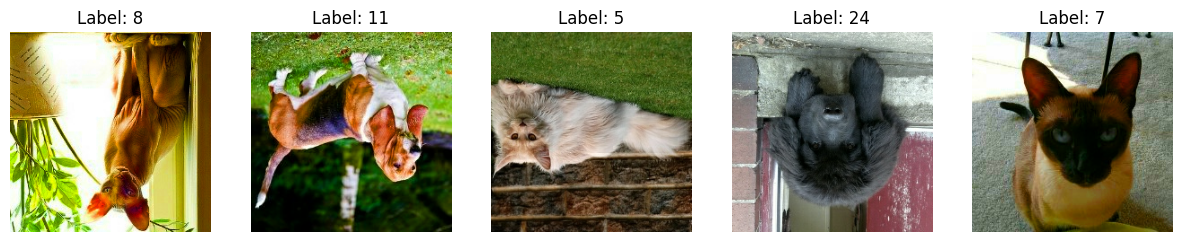

In [98]:
def show_images(dataset, num_images=5):
    """Zobrazí první 'num_images' obrázků z datasetu."""
    plt.figure(figsize=(15, 15))  # Nastavení velikosti obrázku
    for images, labels in dataset.take(8):  # Vezmeme první batch
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)  # Připravíme subploty
            plt.imshow(images[i].numpy())  # Zobrazíme obrázek
            plt.title(f'Label: {labels[i].numpy()}')  # Zobrazíme štítek
            plt.axis("off")
    plt.show()

show_images(train)

# zobrazí změněné trénovací obrázky

## Fitting model

In [26]:
# Fit your model using early stopping

In [52]:
epochs = 6 # pro epochs 6 to vyšlo nejlépe pro nás, pokud by se měnil model mění se asi i epochs

early_call = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', patience=3, restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/train')

model.fit(train,
          epochs=epochs,
          validation_data=dev,
          callbacks=[early_call])

Epoch 1/6
     67/Unknown - 108s 2s/step - loss: 7.2177 - sparse_categorical_accuracy: 0.1779WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
67/67 [==============================] - 123s 2s/step - loss: 7.2177 - sparse_categorical_accuracy: 0.1779 - val_loss: 3.9914 - val_sparse_categorical_accuracy: 0.6340
Epoch 2/6
67/67 [==============================] - 124s 2s/step - loss: 3.9849 - sparse_categorical_accuracy: 0.4556 - val_loss: 2.3042 - val_sparse_categorical_accuracy: 0.7941
Epoch 3/6
67/67 [==============================] - 122s 2s/step - loss: 2.6884 - sparse_categorical_accuracy: 0.6265 - val_loss: 1.7686 - val_sparse_categorical_accuracy: 0.8399
Epoch 4/6
67/67 [==============================] - 123s 2s/step - loss: 2.0924 - sparse_categorical_accuracy: 0.6933 - val_loss: 1.5062 - val_sparse_categorical_accuracy: 0.8529
E

# Evaluation

Load test dataset, predict labels and store results. Note that (for educational purposes) we load the data from pickled list. Therefore, transformation to Tensorflow dataset has to be done.

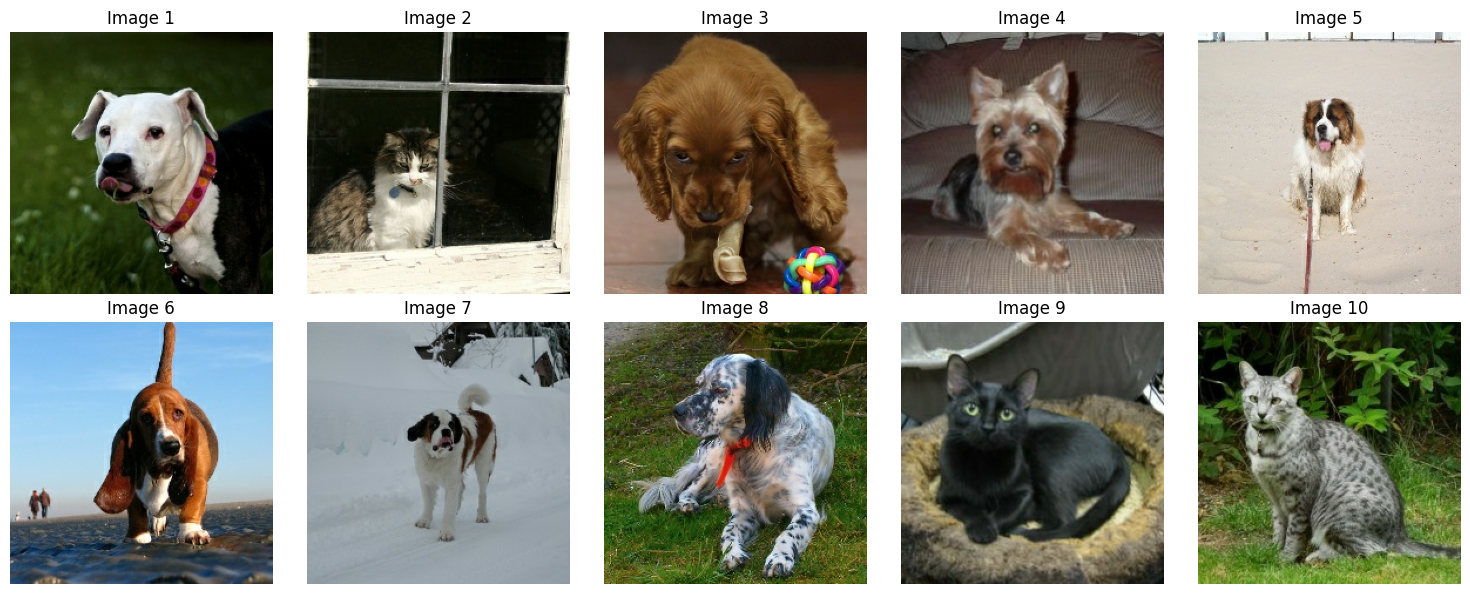

In [99]:
# Načtení dat
with open('hw2_outofsample.pickle', 'rb') as handle:
    test_images = pickle.load(handle)

# Vytvoření TensorFlow Dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

# Nastavení počtu obrázků k zobrazení a počtu obrázků v jednom řádku
num_images_to_display = 10  # Celkový počet obrázků k zobrazení
images_per_row = 5  # Počet obrázků na řádek

# Výpočet počtu řádků potřebných pro zobrazení obrázků
num_rows = (num_images_to_display + images_per_row - 1) // images_per_row  # Používáme celočíselné dělení

# Iterace přes dataset a zobrazení obrázků
plt.figure(figsize=(15, 3 * num_rows))  # Nastavení velikosti obrázku
for i, image in enumerate(test_dataset.take(num_images_to_display)):
    plt.subplot(num_rows, images_per_row, i + 1)  # Vytvoření podgrafu pro každý obrázek
    plt.imshow(image.numpy())  # Zobrazení obrázku
    plt.title(f'Image {i + 1}')
    plt.axis('off')  # Skrytí os

plt.tight_layout()  # Automatické upravení rozložení podgrafů, aby byly lépe uspořádané
plt.show()  # Zobrazení celého obrázku s podgrafy

# trochu zbytečné, ale kdyžtak se dají porovnat výstupy

In [54]:
# Load test dataset stored as pickled list.
with open('hw2_outofsample.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Produce dataset from list
test = tf.data.Dataset.from_tensor_slices(test)

# Apply batching also to 'test'
#test = ...
batch_size = 32  # Můžete použít stejnou velikost batche jako při tréninku
test = test.batch(batch_size)

test_prediction_prob = model.predict(test)
test_prediction = [
    np.argmax(probs) for probs in test_prediction_prob
]

In [94]:
# Store results
pd.DataFrame({'ID,TARGET': test_prediction}).to_csv('data/hw2_outofsample_prediction.csv', index=True, header=True)